In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
DATAPATH = r'.\data\stock_prices_sample.csv'
data = pd.read_csv(DATAPATH, index_col=['DATE'], parse_dates=['DATE'])
data = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Intraday']
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']
data.drop(drop_cols, axis=1, inplace=True)

In [3]:
data.shape

(995, 5)

In [4]:
data.head(5)

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100
2018-06-01,GF,18.58,18.760,18.5800,18.7400
2018-05-31,GF,18.52,18.520,18.3012,18.4900
2018-05-30,GF,18.47,18.678,18.4700,18.6500
2018-05-29,GF,18.51,18.510,18.1500,18.2562


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data.iloc[:,1:2])

train test split

In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

666 329


In [7]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

If you compare these first 3 rows to the original dataset sample listed in the previous section, you can see the X=t and Y=t+1 pattern in the numbers.

In [8]:
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: **samples, time steps, features]**.

In [9]:
print(trainX.shape)
print(testX.shape)

(635, 30)
(298, 30)


Currently, our data is in the form: **[samples, features]** and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [10]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(635, 1, 30)
(298, 1, 30)


In [11]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 635 samples
Epoch 1/100
635/635 - 2s - loss: 0.0587
Epoch 2/100
635/635 - 1s - loss: 0.0020
Epoch 3/100
635/635 - 1s - loss: 0.0016
Epoch 4/100
635/635 - 1s - loss: 0.0013
Epoch 5/100
635/635 - 1s - loss: 0.0013
Epoch 6/100
635/635 - 1s - loss: 0.0013
Epoch 7/100
635/635 - 1s - loss: 0.0012
Epoch 8/100
635/635 - 1s - loss: 0.0011
Epoch 9/100
635/635 - 1s - loss: 0.0010
Epoch 10/100
635/635 - 1s - loss: 9.9982e-04
Epoch 11/100
635/635 - 1s - loss: 0.0010
Epoch 12/100
635/635 - 1s - loss: 9.7680e-04
Epoch 13/100
635/635 - 1s - loss: 8.8119e-04
Epoch 14/100
635/635 - 1s - loss: 8.6291e-04
Epoch 15/100
635/635 - 1s - loss: 9.4038e-04
Epoch 16/100
635/635 - 1s - loss: 8.6156e-04
Epoch 17/100
635/635 - 1s - loss: 8.3226e-04
Epoch 18/100
635/635 - 1s - loss: 7.9216e-04
Epoch 19/100
635/635 - 1s - loss: 7.7985e-0

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

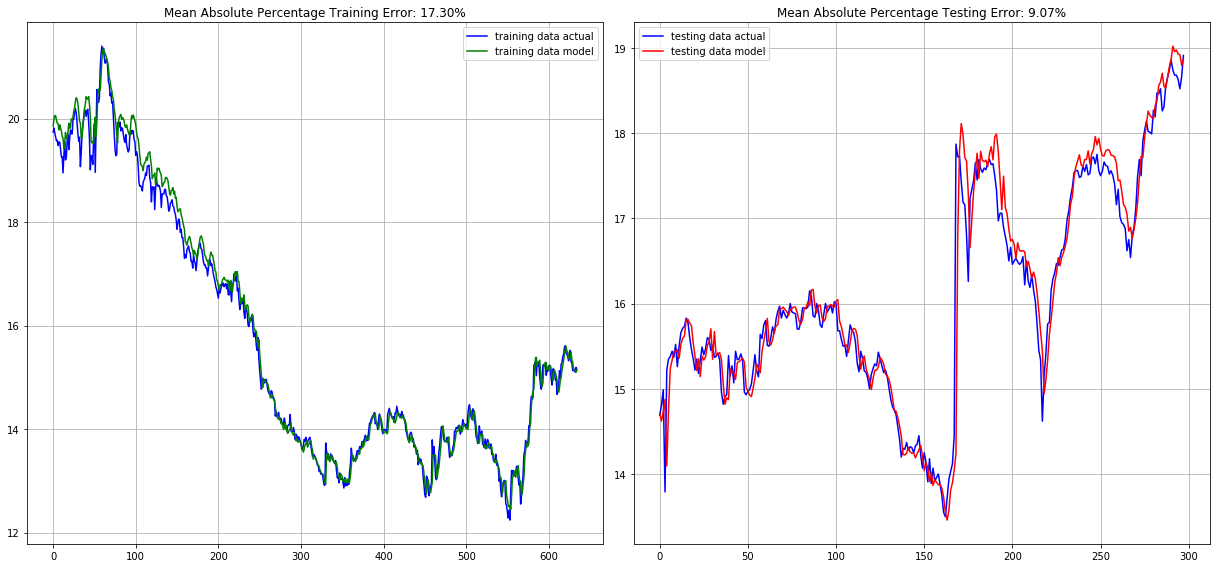

In [13]:
trainError = mean_absolute_percentage_error(trainPredict, trainY)
testError = mean_absolute_percentage_error(testPredict, testY)
layout = (1,2)
plt.figure(figsize=(17, 8))
plt.subplot2grid(layout, (0,0))
plt.plot(trainY[0], color='b', label='training data actual')
plt.plot(trainPredict , color='g', label='training data model')
plt.legend()
plt.grid(True)
plt.title('Mean Absolute Percentage Training Error: {0:.2f}%'.format(trainError))
plt.subplot2grid(layout, (0,1))
plt.plot(testY[0], color='b', label='testing data actual')
plt.plot(testPredict , color='r', label='testing data model')
plt.title('Mean Absolute Percentage Testing Error: {0:.2f}%'.format(testError))
plt.legend()
plt.grid(True);



plt.tight_layout()

In [14]:
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [34]:
testPredict.shape

(298, 1)